In [1]:
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.5 MB/s eta 0:00:00


In [9]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from data_utils import load_dataset
from models import AttentionLSTMModel, LSTMModel, init_model
from train_utils import train_model
from backtest import Backtester

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [10]:
TICKER = 'GC=F'
START_DATE = '2005-01-01'
END_DATE = '2024-01-01'
SEQ_LEN = 90
TRAIN_SPLIT = 0.85
BATCH_SIZE = 64
EPOCHS = 25

In [11]:
train_ds, test_ds, scaler, df = load_dataset(
    TICKER,
    seq_len=SEQ_LEN,
    train_split=TRAIN_SPLIT,
    start=START_DATE,
    end=END_DATE
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training data shape: {train_ds.X.shape}")
print(f"Testing data shape: {test_ds.X.shape}")

Training data shape: torch.Size([3950, 90, 8])
Testing data shape: torch.Size([624, 90, 8])


In [12]:
input_size = train_ds.X.shape[2]
params = {
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.3,
}
model, optimizer, criterion, device = init_model(AttentionLSTMModel, input_size=input_size, **params)
print(f"Model initialized on device: {device}")

Model initialized on device: cuda


In [13]:
train_losses, val_losses = train_model(
    model, optimizer, criterion, train_loader,
    test_loader, device, epochs=EPOCHS
)

Epoch [1/25]  Train Loss: 0.000213  Val Loss: 0.000080
Epoch [2/25]  Train Loss: 0.000141  Val Loss: 0.000082
Epoch [3/25]  Train Loss: 0.000142  Val Loss: 0.000083
Epoch [4/25]  Train Loss: 0.000140  Val Loss: 0.000082
Epoch [5/25]  Train Loss: 0.000142  Val Loss: 0.000083
Epoch [6/25]  Train Loss: 0.000140  Val Loss: 0.000080
Epoch [7/25]  Train Loss: 0.000141  Val Loss: 0.000091
Epoch [8/25]  Train Loss: 0.000143  Val Loss: 0.000085
Epoch [9/25]  Train Loss: 0.000139  Val Loss: 0.000109
Epoch [10/25]  Train Loss: 0.000140  Val Loss: 0.000080
Epoch [11/25]  Train Loss: 0.000139  Val Loss: 0.000081
Epoch [12/25]  Train Loss: 0.000141  Val Loss: 0.000081
Epoch [13/25]  Train Loss: 0.000140  Val Loss: 0.000088
Epoch [14/25]  Train Loss: 0.000143  Val Loss: 0.000080
Epoch [15/25]  Train Loss: 0.000141  Val Loss: 0.000081
Epoch [16/25]  Train Loss: 0.000139  Val Loss: 0.000081
Epoch [17/25]  Train Loss: 0.000139  Val Loss: 0.000096
Epoch [18/25]  Train Loss: 0.000139  Val Loss: 0.000090
E

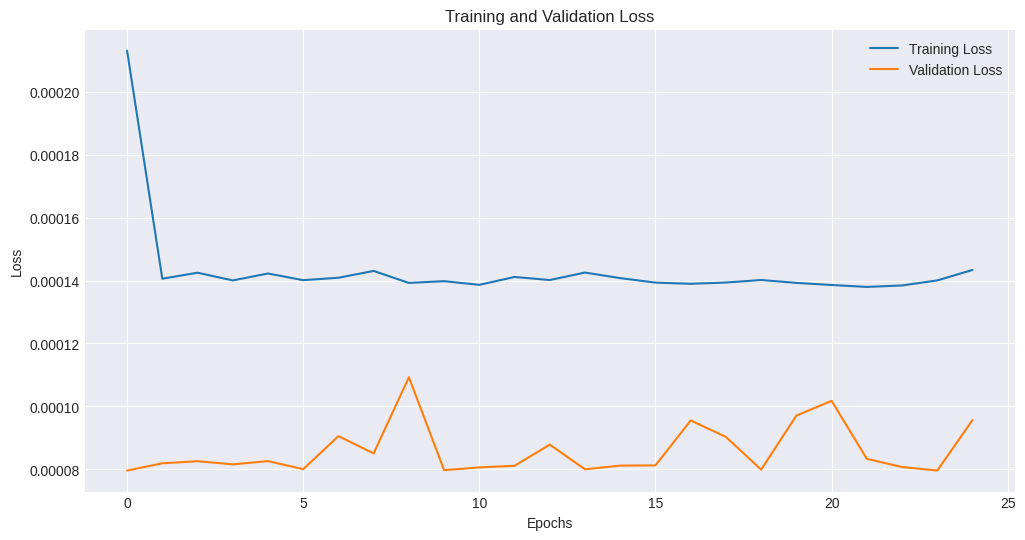

In [14]:
# --- Plot Training Loss ---
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# --- Run Backtest and Visualize Results ---
backtest_results = Backtester.from_model_output(
    model, test_loader, device=device, target_vol=0.15,
    alpha=10.0, max_leverage=1.5, fees=0.001
)
portfolio = backtest_results['portfolio']

print("\n--- Plotting Cumulative Returns (PNL Graph) ---")
portfolio.plot().show()

print("\n--- Plotting Drawdowns ---")
portfolio.plot_drawdowns().show()

print("\n--- Plotting Positions ---")
portfolio.plot_positions().show()

# --- Rolling Sharpe Ratio ---
print("\n--- Plotting Rolling Sharpe Ratio ---")
rolling_sharpe = portfolio.rolling_sharpe(window=100)
rolling_sharpe.plot(title='Rolling Sharpe Ratio (100-day window)')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'